In [2]:
import pandas as pd
import numpy as np

# Load the dataset
file_path = 'learner_engagement.csv'
learner_engagement_df = pd.read_csv(file_path)

# Step 1: Remove duplicates
learner_engagement_df.drop_duplicates(inplace=True)

# Step 2: Handle missing values
# Fill missing categorical values with 'Unknown' and numeric with median or zero
for column in learner_engagement_df.columns:
    if learner_engagement_df[column].dtype == 'object':
        learner_engagement_df[column].fillna('Unknown', inplace=True)
    else:
        learner_engagement_df[column].fillna(learner_engagement_df[column].median(), inplace=True)

# Step 3: Correct data types
# Convert date columns to datetime format
learner_engagement_df['Learner SignUp DateTime'] = pd.to_datetime(learner_engagement_df['Learner SignUp DateTime'], errors='coerce')
learner_engagement_df['Opportunity End Date'] = pd.to_datetime(learner_engagement_df['Opportunity End Date'], errors='coerce')
learner_engagement_df['Opportunity Start Date'] = pd.to_datetime(learner_engagement_df['Opportunity Start Date'], errors='coerce')

# Step 4: Drop unnecessary columns if needed (example with placeholder columns)
# Modify the list of columns to drop as needed
columns_to_drop = ['Opportunity Id', 'First Name', 'Last Name', 'Mobile Number', 'Address Line 1', 'Address Line 2', 'Zip Code', 'Badge Id', 'Badge Name', 'Opportunity Duration (Days)', 'Opportunity Engagement (Days)', 'Age and Duration Interaction', 'Duration Weight (50%)', 'Age Weight (30%)', 'Gender Weight (20%)', 'Engagement Scores', 'Normalized Reward Amount', 'Gender Data Encoding', 'Status Code', 'Normalized Skill Points Earned']  # Replace with any columns you consider irrelevant
learner_engagement_df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Save the cleaned dataset
eda_cleaned_file_path = 'eda_engagement.csv'
learner_engagement_df.to_csv(eda_cleaned_file_path, index=False)
print(f"Cleaned data saved to {eda_cleaned_file_path}")

# Load the cleaned data
eda_cleaned_df = pd.read_csv(eda_cleaned_file_path)

# Parse dates for calculations
eda_cleaned_df['Opportunity Start Date'] = pd.to_datetime(eda_cleaned_df['Opportunity Start Date'], errors='coerce')
eda_cleaned_df['Opportunity End Date'] = pd.to_datetime(eda_cleaned_df['Opportunity End Date'], errors='coerce')
eda_cleaned_df['Completion Date'] = pd.to_datetime(eda_cleaned_df['Completion Date'], errors='coerce')

# 1. Activity Duration in days (intended duration of the activity)
eda_cleaned_df['Activity Duration (Days)'] = (eda_cleaned_df['Opportunity End Date'] - eda_cleaned_df['Opportunity Start Date']).dt.days

# 2. Completion Rate (binary: 1 if completed, 0 otherwise)
eda_cleaned_df['Completion Status'] = eda_cleaned_df['Completion Date'].notna().astype(int)

# 3. Reward Engagement (normalize the Reward Amount)
# Assuming you re-add 'Reward Amount' or have it in your DataFrame
if 'Reward Amount' in eda_cleaned_df.columns:
    eda_cleaned_df['Normalized Reward Engagement'] = (eda_cleaned_df['Reward Amount'] - eda_cleaned_df['Reward Amount'].min()) / (eda_cleaned_df['Reward Amount'].max() - eda_cleaned_df['Reward Amount'].min())

# 4. Frequency of Participation (e.g., in the last year) - requires unique user ID
# Example: Count number of opportunities per learner in the past year
eda_cleaned_df['Participation Frequency'] = eda_cleaned_df.groupby('Profile Id')['Profile Id'].transform('count')

# 5. Time to Completion (for those who completed)
eda_cleaned_df['Time to Completion (Days)'] = (eda_cleaned_df['Completion Date'] - eda_cleaned_df['Opportunity Start Date']).dt.days
eda_cleaned_df['Time to Completion (Days)'] = eda_cleaned_df['Time to Completion (Days)'].fillna(eda_cleaned_df['Activity Duration (Days)'])

# 6. New Engagement Score Calculation - Combine the above metrics
# A simple weighted sum can serve as a new engagement score
eda_cleaned_df['Engagement Score'] = (
    eda_cleaned_df['Completion Status'] * 0.4 +               # 40% weight on completion
    eda_cleaned_df['Normalized Reward Engagement'].fillna(0) * 0.3 +  # 30% weight on reward engagement
    (1 / (1 + eda_cleaned_df['Time to Completion (Days)'])) * 0.2 +   # 20% weight on time to completion (lower time, higher score)
    (eda_cleaned_df['Participation Frequency'] / eda_cleaned_df['Participation Frequency'].max()) * 0.1  # 10% weight on participation frequency
)

# Replace blank cells in 'Opportunity Start Date' and 'Completion Date' with 'Null' string
eda_cleaned_df['Opportunity Start Date'] = eda_cleaned_df['Opportunity Start Date'].fillna('Null')
eda_cleaned_df['Completion Date'] = eda_cleaned_df['Completion Date'].fillna('Null')

# Replace blank cells in 'Activity Duration (Days)' and 'Time to Completion (Days)' with zero integer
eda_cleaned_df['Activity Duration (Days)'] = eda_cleaned_df['Activity Duration (Days)'].fillna(0).astype(int)
eda_cleaned_df['Time to Completion (Days)'] = eda_cleaned_df['Time to Completion (Days)'].fillna(0).astype(int)

# Replace blank cells in 'New Engagement Score' with zero float
eda_cleaned_df['Engagement Score'] = eda_cleaned_df['Engagement Score'].fillna(0.000000).astype(float)

# Display the updated DataFrame with new features
eda_cleaned_df[['Activity Duration (Days)', 'Completion Status', 'Normalized Reward Engagement', 
      'Participation Frequency', 'Time to Completion (Days)', 'Engagement Score']].head()

# Save the cleaned dataset
features_and_scores_file_path = 'features_and_scores.csv'
eda_cleaned_df.to_csv(features_and_scores_file_path, index=False)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the features and scores data
features_and_scores_df = pd.read_csv(features_and_scores_file_path)

# Calculate descriptive statistics for numerical columns excluding 'Learner SignUp Year' and 'Normalized Reward Engagement'
descriptive_stats = features_and_scores_df.drop(columns=['Learner SignUp Year', 'Normalized Reward Engagement']).describe(include=[float, int])
descriptive_stats

Cleaned data saved to eda_engagement.csv


,Age Calculation,Reward Amount,Activity Duration (Days),Completion Status,Participation Frequency,Time to Completion (Days),Engagement Score
count,8202.000000,8202.000000,8202.000000,8202.000000,8202.00000,8202.000000,8202.000000
mean,24.559863,0.292612,131.016459,0.003292,4.11168,130.797245,inf
std,4.333988,6.336668,230.950285,0.057284,3.38123,230.584725,NaN
min,13.000000,0.000000,-24.000000,0.000000,1.00000,-24.000000,-0.026667
25%,22.000000,0.000000,0.000000,0.000000,1.00000,0.000000,0.000000
50%,24.000000,0.000000,0.000000,0.000000,3.00000,0.000000,0.000000
75%,26.000000,0.000000,94.000000,0.000000,6.00000,94.000000,0.013760
max,58.000000,200.000000,604.000000,1.000000,15.00000,604.000000,inf


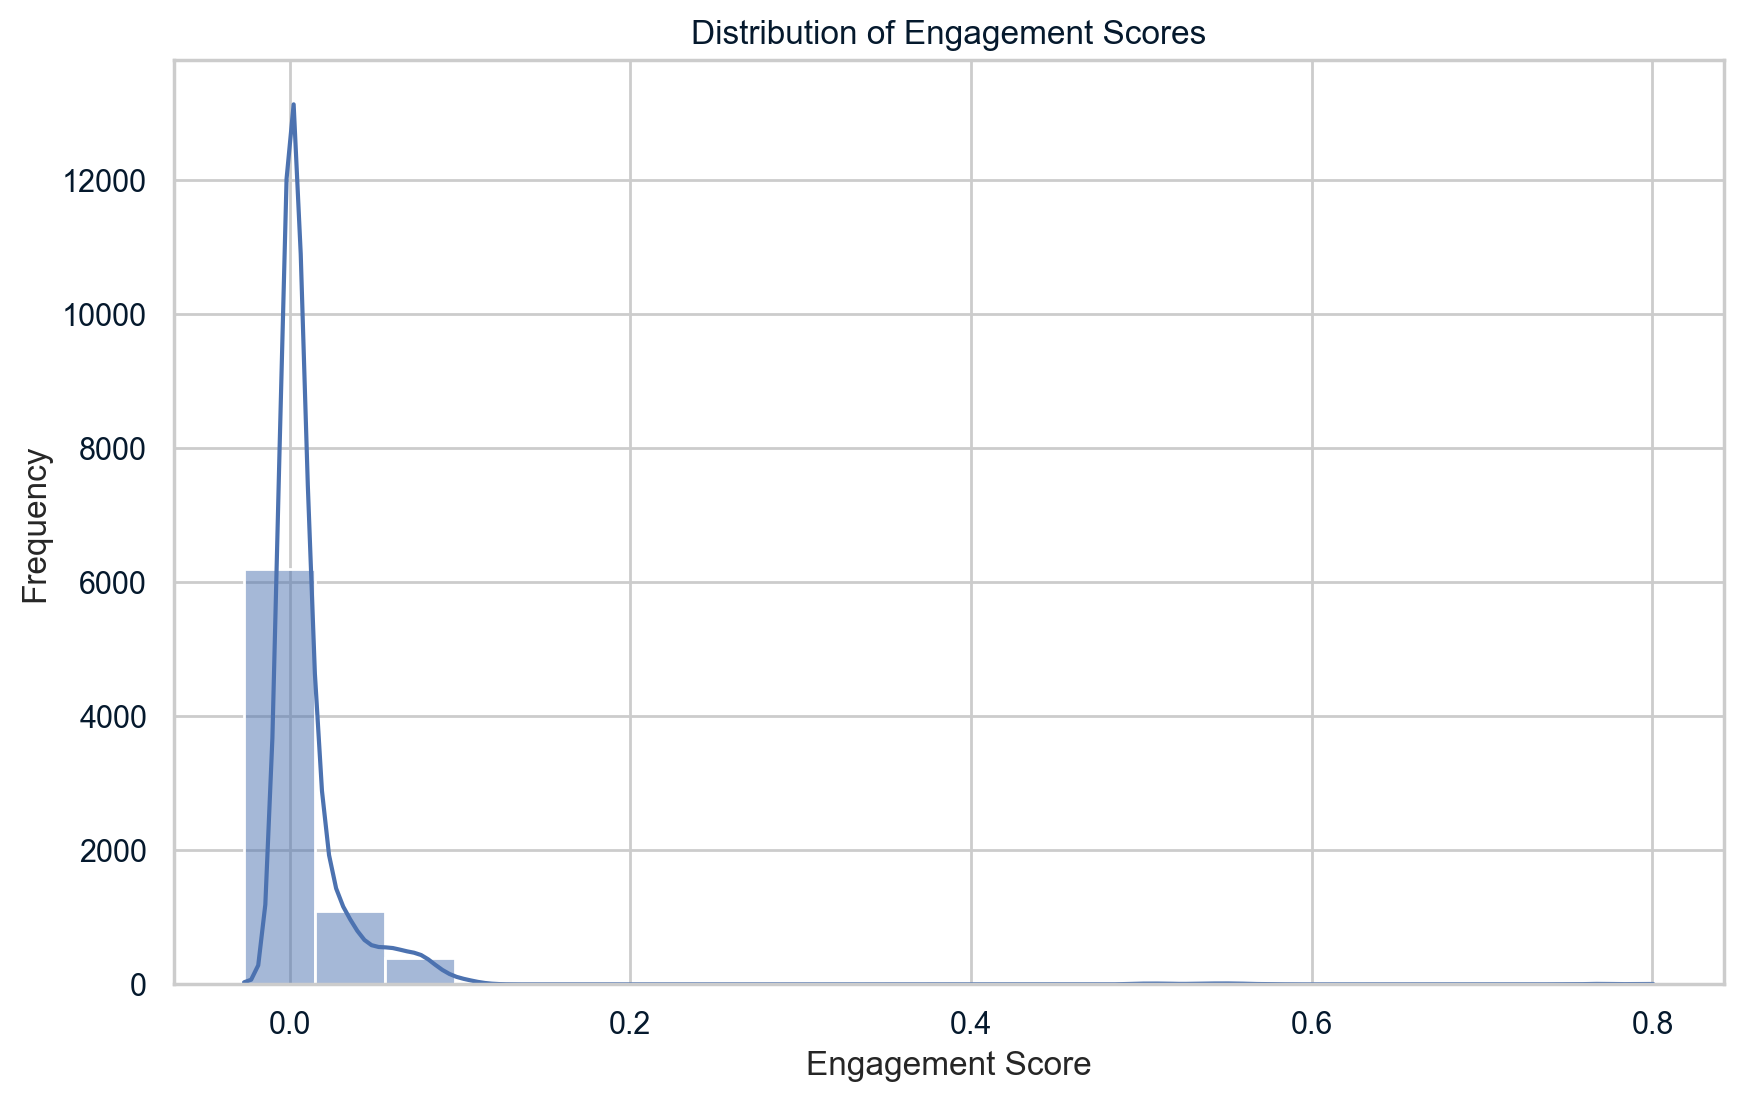

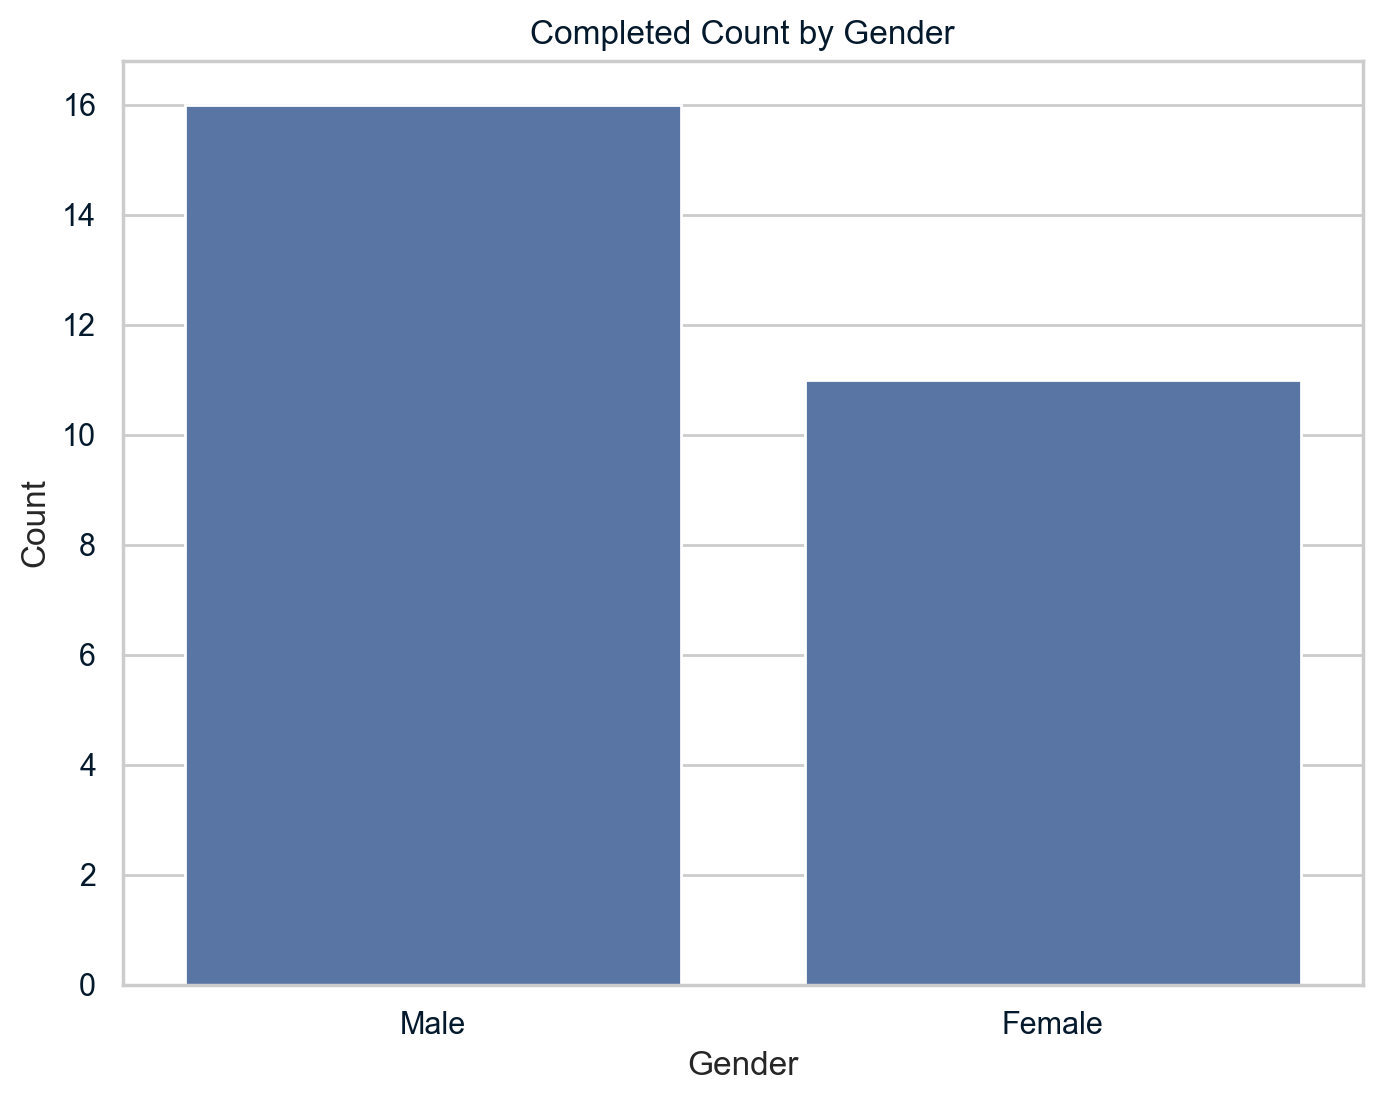

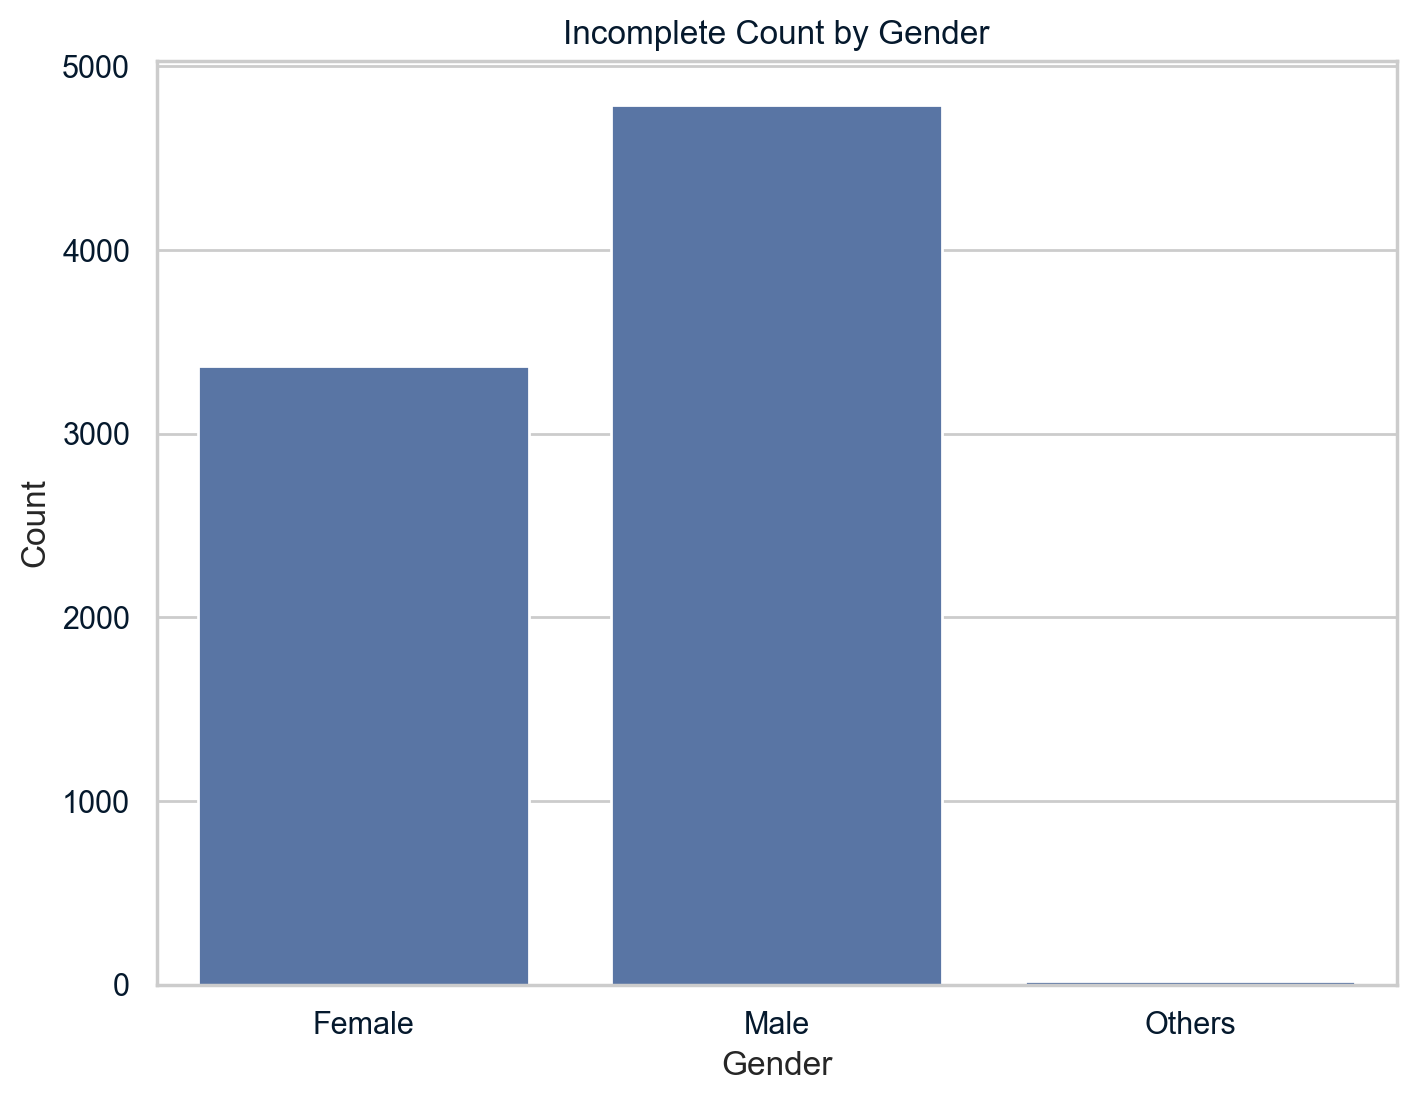

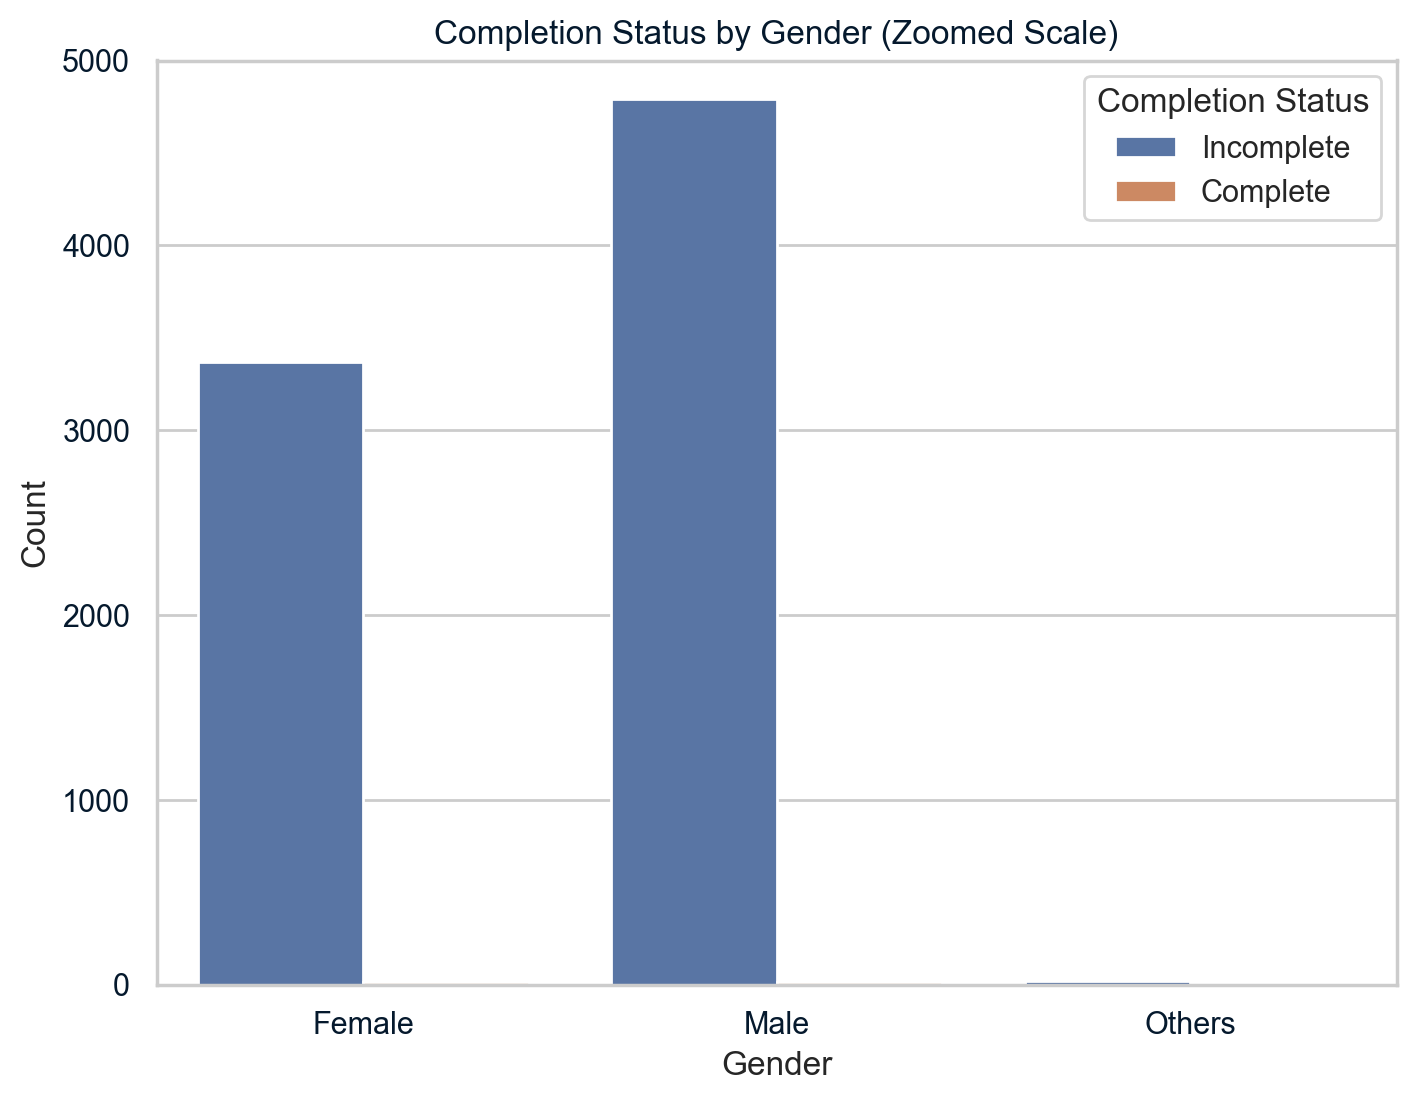

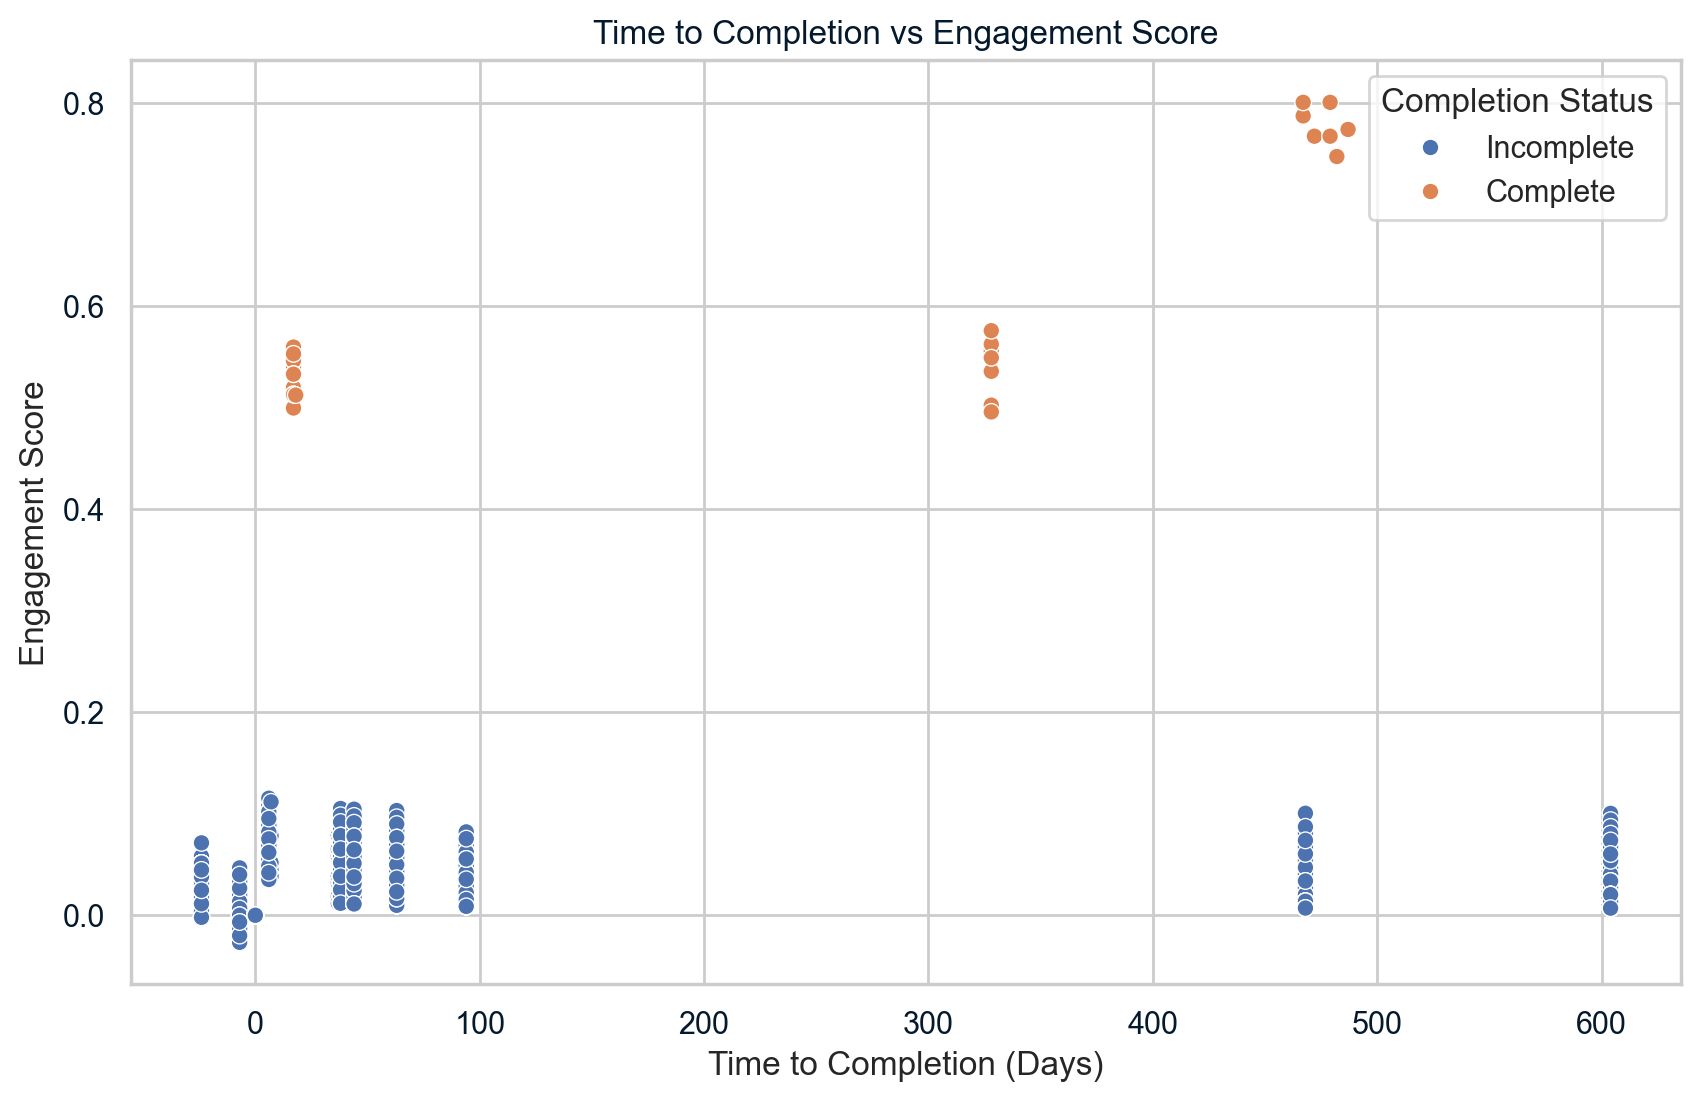

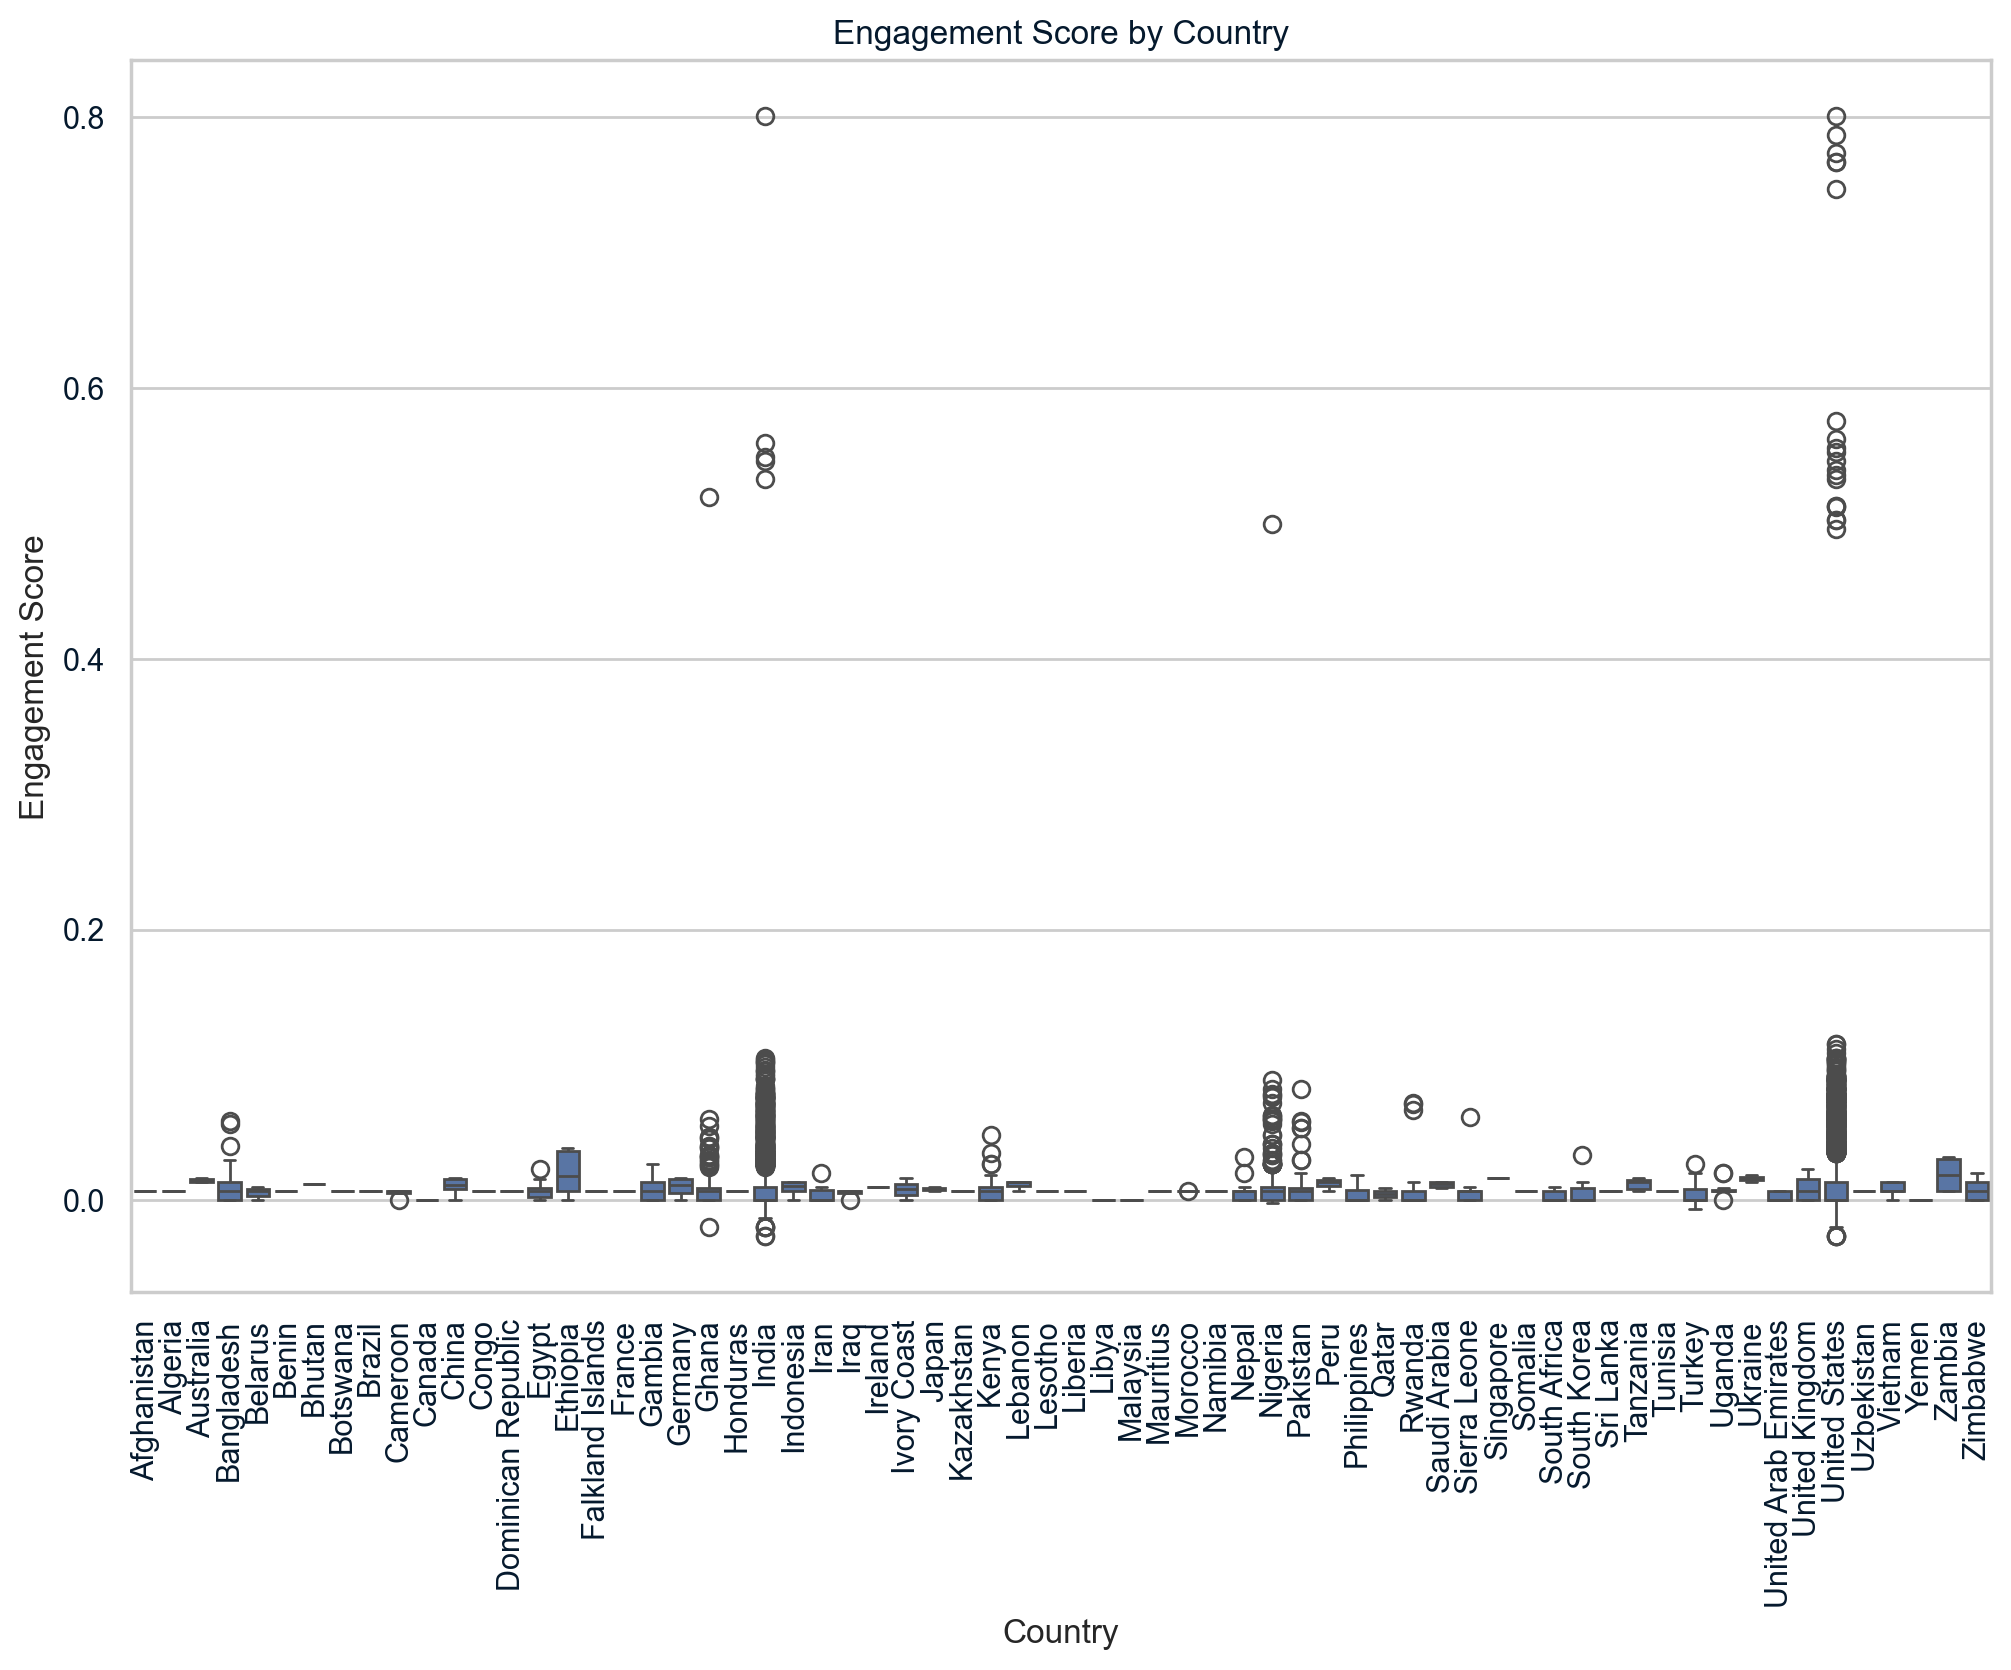

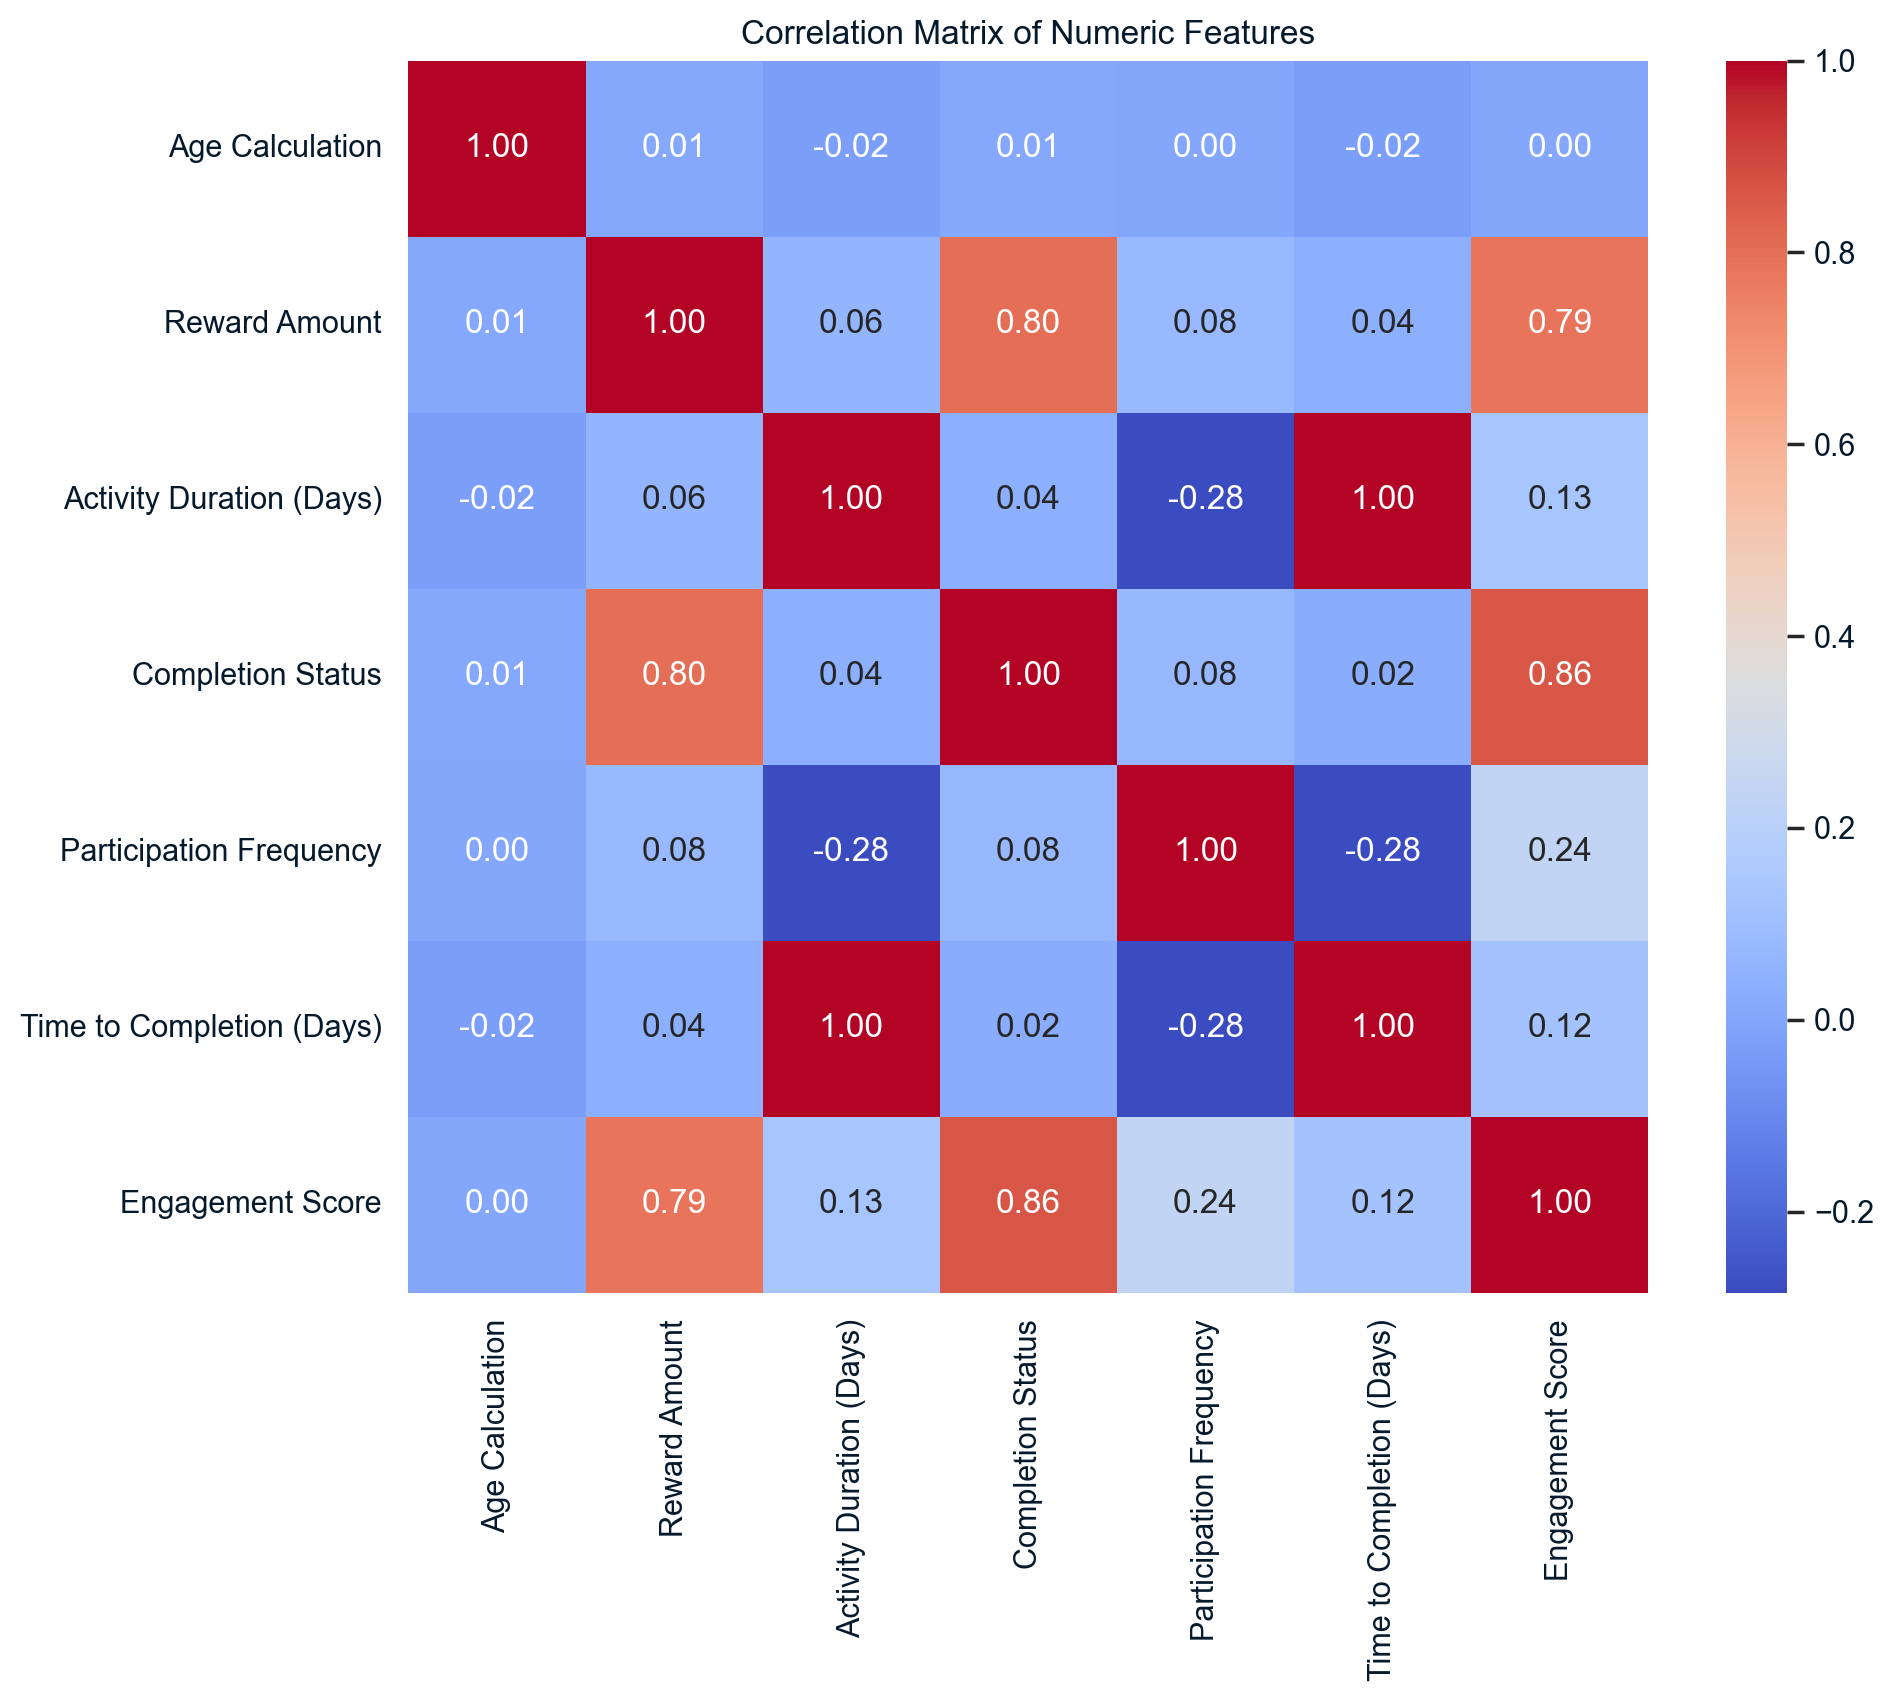

Anomalies in Engagement Scores:
              City  Gender  Engagement Score  Completion Status
0        Peshawar  Female          0.006997                  0
1       Vikarabad  Female          0.006997                  0
2         Chicago    Male          0.006997                  0
3     Saint Louis  Female          0.086997                  0
4     Saint Louis    Male          0.006997                  0
...           ...     ...               ...                ...
8197  Addis Ababa  Female               inf                  0
8198  Saint Louis    Male               inf                  0
8199       Kosofe    Male               inf                  0
8200  Saint Louis  Female               inf                  0
8201   Hanamkonda    Male               inf                  0

[8177 rows x 4 columns]


In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the updated dataset
file_path = 'features_and_scores.csv'
features_and_scores_df = pd.read_csv(file_path)

# 1. Descriptive Statistics
# Calculate descriptive statistics for numerical columns excluding 'Learner SignUp Year' and 'Normalized Reward Engagement'
descriptive_stats = features_and_scores_df.drop(columns=['Learner SignUp Year', 'Normalized Reward Engagement']).describe(include=[float, int])
descriptive_stats

# 2. Visualization
# Set up the style for seaborn plots
sns.set(style="whitegrid")

# a. Histogram for New Engagement Score with bars breakdown in granular view
plt.figure(figsize=(10, 6))
histplot = sns.histplot(features_and_scores_df['Engagement Score'], bins=20, kde=True)  # Increased number of bins for granular view
plt.title('Distribution of Engagement Scores')
plt.xlabel('Engagement Score')
plt.ylabel('Frequency')
plt.show()

# b. Completion Rate by Gender for Completed Count Only
completed_df = features_and_scores_df[features_and_scores_df['Completion Status'] == 1]
plt.figure(figsize=(8, 6))
sns.countplot(x='Gender', data=completed_df)
plt.title('Completed Count by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

# c. Completion Rate by Gender for Incomplete Count Only
incomplete_df = features_and_scores_df[features_and_scores_df['Completion Status'] == 0]
plt.figure(figsize=(8, 6))
sns.countplot(x='Gender', data=incomplete_df)
plt.title('Incomplete Count by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

# d. Completion Status by Gender for Both Completed and Incomplete Count in Zoomed Scale
plt.figure(figsize=(8, 6))
sns.countplot(x='Gender', hue='Completion Status', data=features_and_scores_df)
plt.ylim(0, 5000)  # Adjust the y-axis limit to zoom in on low counts
plt.title('Completion Status by Gender (Zoomed Scale)')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Completion Status', labels=['Incomplete', 'Complete'])
plt.show()

# e. Scatter plot of Time to Completion vs. Engagement Score
plt.figure(figsize=(10, 6))
scatterplot = sns.scatterplot(x='Time to Completion (Days)', y='Engagement Score', hue='Completion Status', data=features_and_scores_df)
plt.title('Time to Completion vs Engagement Score')
plt.xlabel('Time to Completion (Days)')
plt.ylabel('Engagement Score')

# Align label color to the scatter plot representation
handles, labels = scatterplot.get_legend_handles_labels()
plt.legend(handles=handles, labels=['Incomplete', 'Complete'], title='Completion Status')
plt.show()

# d. Boxplot for New Engagement Score by City (to see city-wise engagement)
plt.figure(figsize=(12, 8))
# Sort the dataframe by 'Country' to arrange country names in alphabetical order
features_and_scores_df_sorted = features_and_scores_df.sort_values('Country')
sns.boxplot(x='Country', y='Engagement Score', data=features_and_scores_df_sorted)
plt.xticks(rotation=90)
plt.title('Engagement Score by Country')
plt.xlabel('Country')
plt.ylabel('Engagement Score')
plt.show()

# Select only the numeric columns for correlation calculation, excluding 'Learner SignUp Year' and 'Normalized Reward Engagement'
numeric_data = features_and_scores_df.drop(columns=['Learner SignUp Year', 'Normalized Reward Engagement']).select_dtypes(include=['number'])

# Calculate the correlation matrix for numeric columns
correlation_matrix = numeric_data.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numeric Features')
plt.show()

#Check for anomalies in engagement scores (e.g., very low or high scores)
anomalies = features_and_scores_df[(features_and_scores_df['Engagement Score'] < 0.2) | (features_and_scores_df['Engagement Score'] > 0.8)]
print("Anomalies in Engagement Scores:\n", anomalies[['City', 'Gender', 'Engagement Score', 'Completion Status']])

Classification Report for Logistic Regression:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2453
           1       1.00      1.00      1.00         8

    accuracy                           1.00      2461
   macro avg       1.00      1.00      1.00      2461
weighted avg       1.00      1.00      1.00      2461



Classification Report for Decision Tree:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2453
           1       1.00      1.00      1.00         8

    accuracy                           1.00      2461
   macro avg       1.00      1.00      1.00      2461
weighted avg       1.00      1.00      1.00      2461



Classification Report for Random Forest:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2453
           1       1.00      1.00      1.00         8

    accuracy                           1.00   

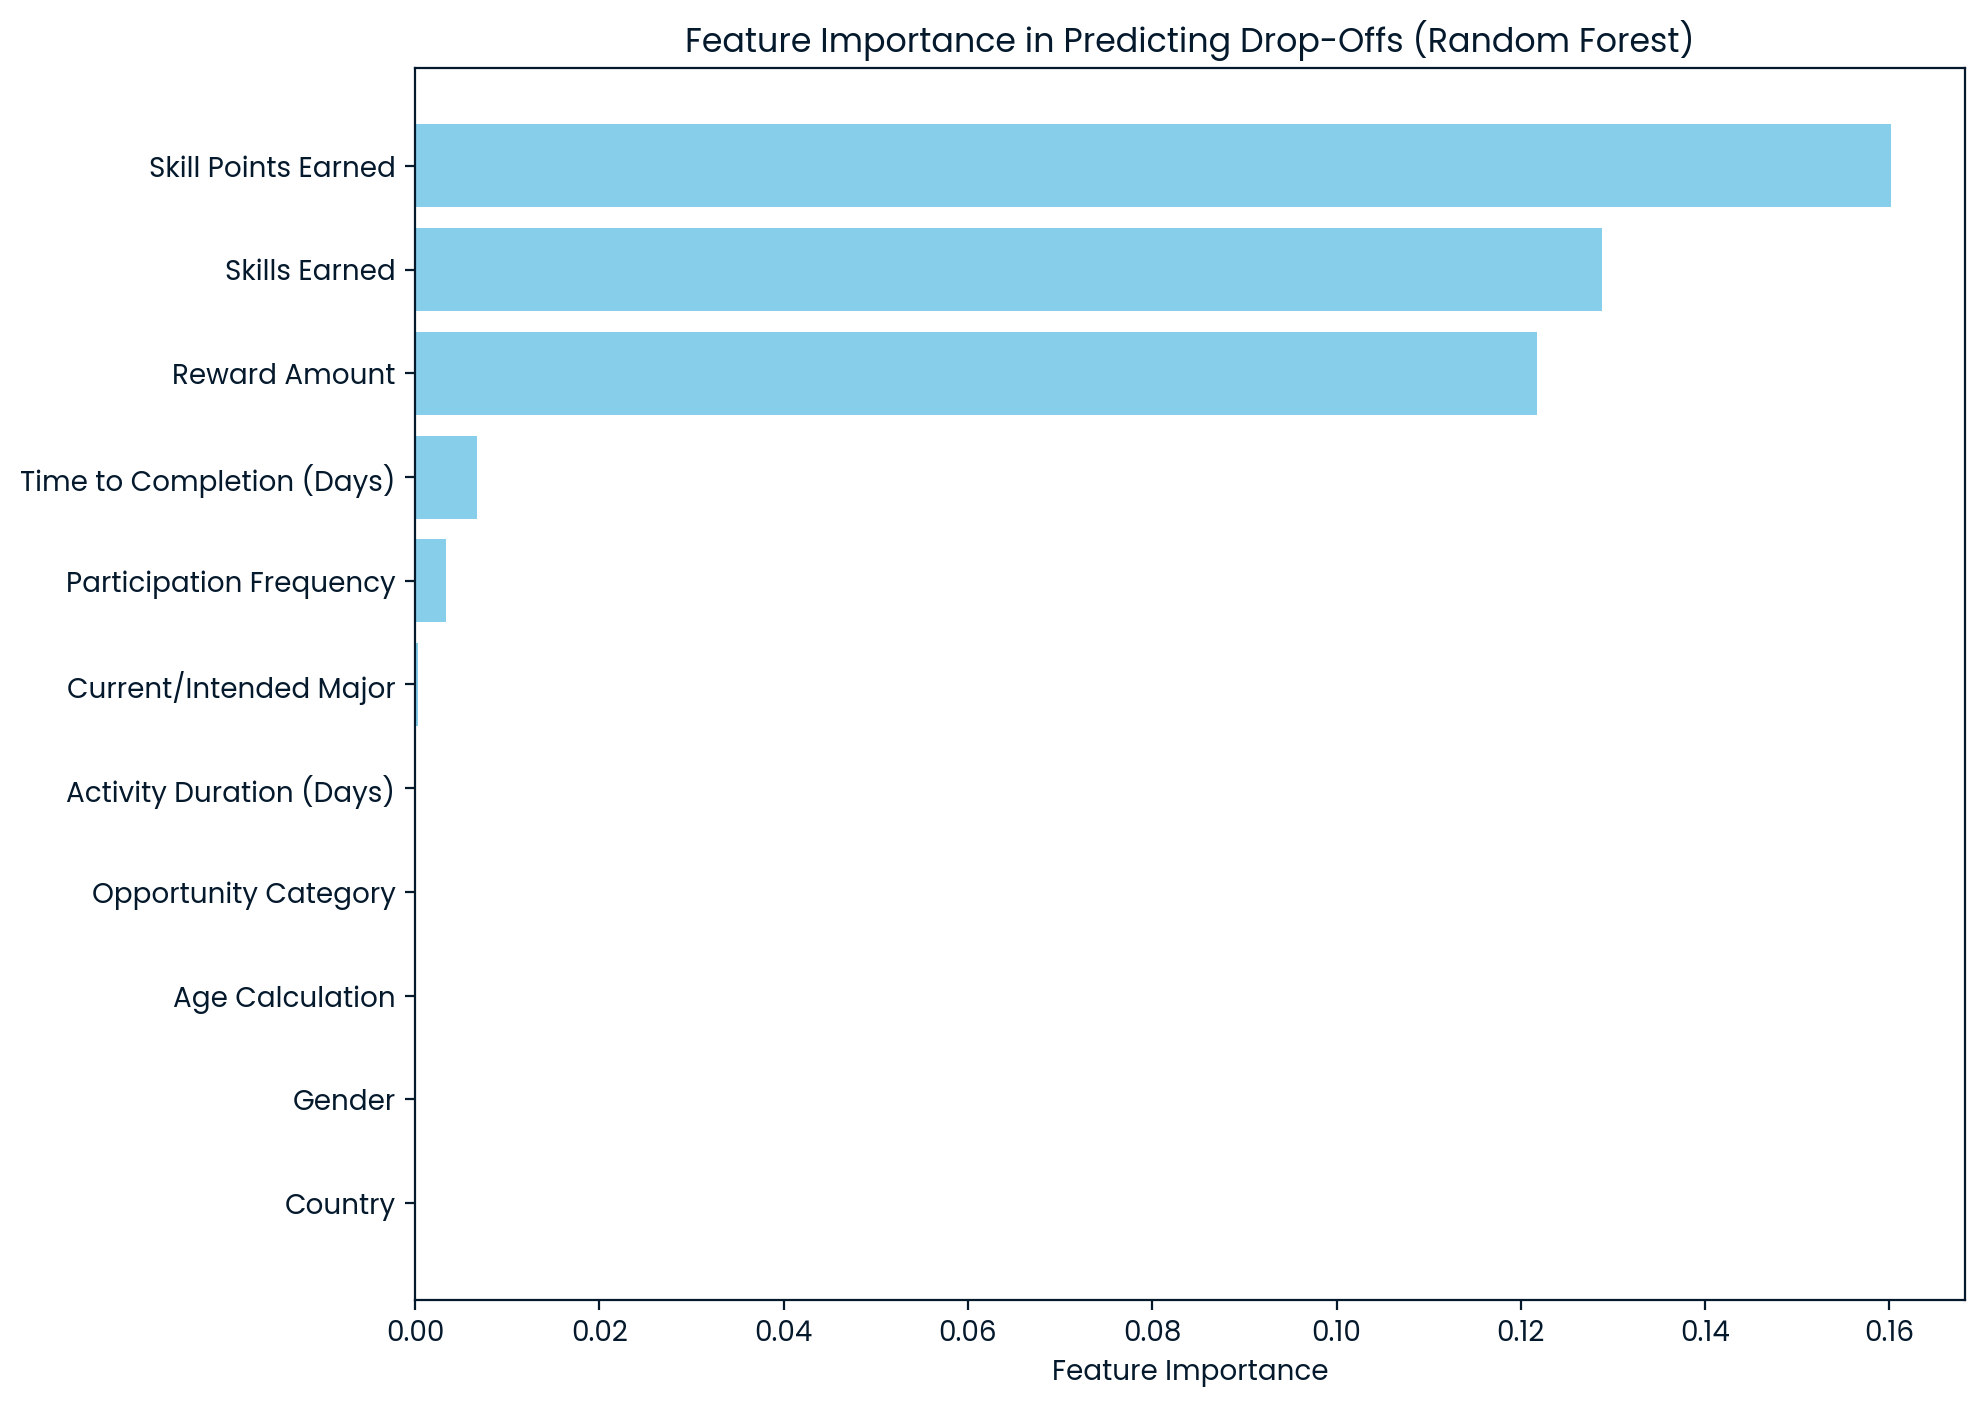

In [10]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder

file_path = 'features_and_scores.csv'
features_and_scores_df = pd.read_csv(file_path)

# Identify categorical columns
categorical_columns = features_and_scores_df.select_dtypes(include=['object']).columns

# Encode categorical columns if necessary
for col in categorical_columns:
    features_and_scores_df[col] = LabelEncoder().fit_transform(features_and_scores_df[col])

# Separate features (X) and target (y)
X = features_and_scores_df.drop(columns=['Engagement Score'])  # 'Completion Status' is assumed to be the target variable
y = features_and_scores_df['Completion Status']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Check for any NaN or infinite values in X_train and X_test
X_train = X_train.replace([np.inf, -np.inf], np.nan)  # Replace infinite values with NaN
X_test = X_test.replace([np.inf, -np.inf], np.nan)
X_train = X_train.fillna(X_train.mean())  # Replace NaNs with column mean in X_train
X_test = X_test.fillna(X_train.mean())  # Replace NaNs in X_test with mean from X_train

# Scale features for better model performance (optional but recommended for Logistic Regression)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Model Selection and Training
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

# Dictionary to store model performances
model_performance = {}

# Train and evaluate each model
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary', pos_label=y_test.unique()[0])
    recall = recall_score(y_test, y_pred, average='binary', pos_label=y_test.unique()[0])
    f1 = f1_score(y_test, y_pred, average='binary', pos_label=y_test.unique()[0])
    
    # Store the results
    model_performance[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }
    
    # Print classification report
    print(f"Classification Report for {model_name}:\n")
    print(classification_report(y_test, y_pred))
    print("\n")

# Display the model performance summary
print("Model Performance Summary:\n", model_performance)

# Feature Importance (for tree-based models only)
selected_features = [
    'Skill Points Earned', 'Skills Earned', 'Reward Amount', 'Time to Completion (Days)',
    'Participation Frequency', 'Age Calculation', 'Gender', 'Opportunity Category',
    'Country', 'Activity Duration (Days)', 'Current/Intended Major'
]

feature_importance = {}
if 'Random Forest' in models:
    rf_model = models['Random Forest']
    importance_values = rf_model.feature_importances_
    feature_importance = dict(zip(X.columns, importance_values))
    filtered_feature_importance = {k: v for k, v in feature_importance.items() if k in selected_features}
    sorted_features = sorted(filtered_feature_importance.items(), key=lambda x: x[1], reverse=True)

    print("\nFeature Importance for Random Forest Model (Selected Features):")
    for feature, importance in sorted_features:
        print(f"{feature}: {importance:.4f}")

# Optional: Visualize Feature Importance (requires matplotlib)
import matplotlib.pyplot as plt

# Plot feature importance for Random Forest if it's available
if feature_importance:
    features, importances = zip(*sorted_features)
    plt.figure(figsize=(10, 8))
    plt.barh(features, importances, color='skyblue')
    plt.xlabel("Feature Importance")
    plt.title("Feature Importance in Predicting Drop-Offs (Random Forest)")
    plt.gca().invert_yaxis()
    plt.show()

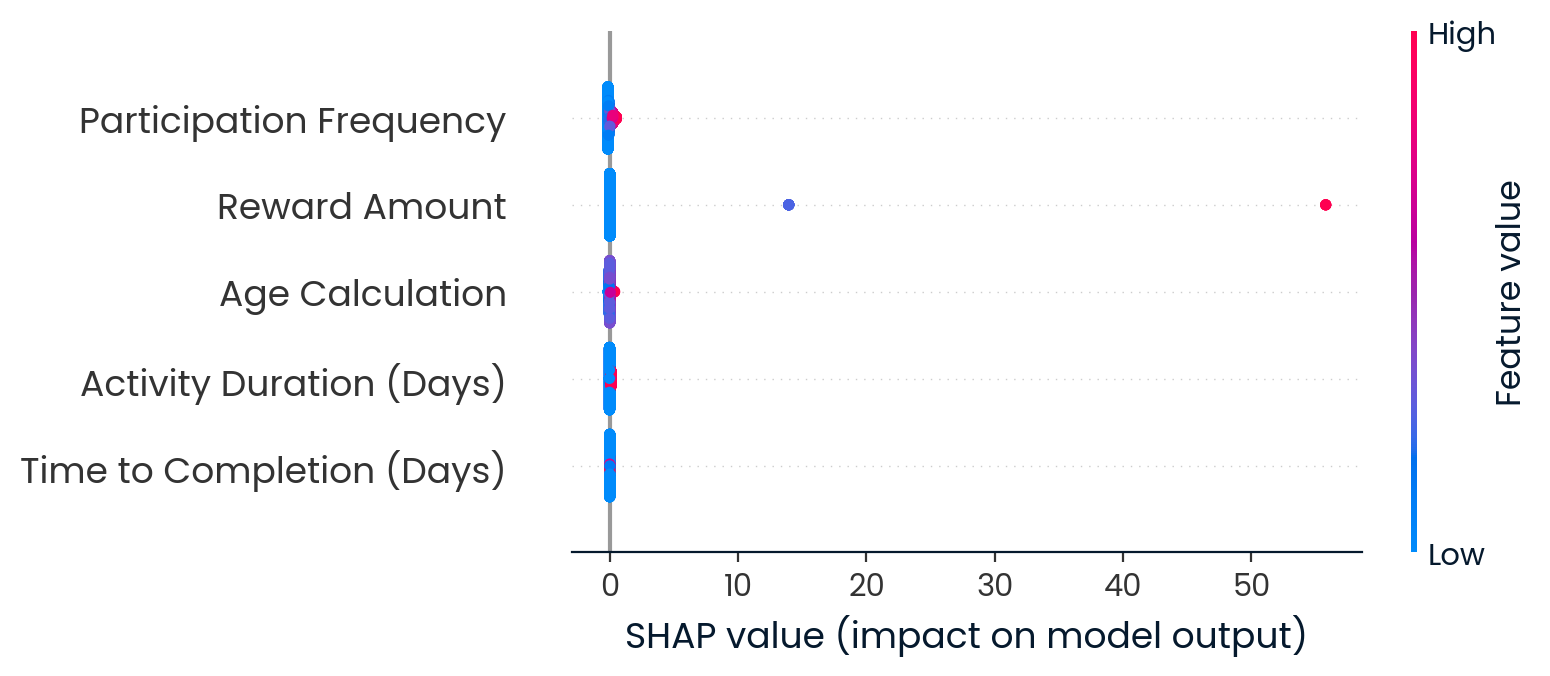


Top Factors Contributing to Churn:
                     Feature  Average Impact on Model Output
3    Participation Frequency                        0.128613
1              Reward Amount                        0.082596
0            Age Calculation                        0.032329
2   Activity Duration (Days)                        0.025478
4  Time to Completion (Days)                        0.001631


In [1]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import shap

# Load the dataset
data = pd.read_csv("features_and_scores.csv")

# Assuming 'drop_off' is the target variable indicating churn
X = data.drop(columns=['Engagement Score', 'Completion Status', 'Normalized Reward Engagement', 'Learner SignUp Year'])  # Feature columns
y = data['Completion Status']  # Target column

# Identify and remove non-numeric columns from X
non_numeric_columns = X.select_dtypes(include=['object']).columns
X = X.drop(columns=non_numeric_columns)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Scale features for better model performance (especially for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a classifier (using logistic regression for interpretability)
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_scaled, y_train)

# Initialize SHAP for interpretability
explainer = shap.LinearExplainer(model, X_train_scaled, feature_names=X.columns)
shap_values = explainer.shap_values(X_train_scaled)

# Plot SHAP summary to highlight primary factors for churn
shap.summary_plot(shap_values, X_train_scaled, feature_names=X.columns)

# Interpretation
print("\nTop Factors Contributing to Churn:")
feature_importance = pd.DataFrame(list(zip(X.columns, abs(shap_values).mean(axis=0))), 
                                  columns=['Feature', 'Average Impact on Model Output'])
feature_importance.sort_values(by='Average Impact on Model Output', ascending=False, inplace=True)
print(feature_importance.head(10))

In [1]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import shap

# Load the dataset
data = pd.read_csv("features_and_scores.csv")

# Assuming 'drop_off' is the target variable indicating churn
X = data.drop(columns=['Engagement Score', 'Completion Status', 'Normalized Reward Engagement', 'Learner SignUp Year'])  # Feature columns
y = data['Completion Status']  # Target column

# Identify and remove non-numeric columns from X
non_numeric_columns = X.select_dtypes(include=['object']).columns
X = X.drop(columns=non_numeric_columns)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Scale features for better model performance (especially for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a classifier (using logistic regression for interpretability)
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_scaled, y_train)

# Predict churn probability for the test set
churn_probabilities = model.predict_proba(X_test_scaled)[:, 1]  # Probability of churn (assuming class 1 indicates churn)

# Define a threshold for identifying at-risk learners (e.g., 0.7 or higher indicates high churn risk)
threshold = 0.7
at_risk_learners = X_test.copy()
at_risk_learners['Churn Probability'] = churn_probabilities
at_risk_learners['At Risk'] = at_risk_learners['Churn Probability'] >= threshold

# Filter out the learners who are at risk
at_risk_learners = at_risk_learners[at_risk_learners['At Risk']]

# Display the at-risk learners with relevant details
print("List of learners needing attention based on churn analysis:")
print(at_risk_learners[['Churn Probability']].sort_values(by='Churn Probability', ascending=False))

# Optionally, save the list to a CSV file for further review
at_risk_learners.to_csv("at_risk_learners.csv", index=False)

# Display the head of the at-risk learners with relevant details
at_risk_learners.head()

at_risk_learners


List of learners needing attention based on churn analysis:
      Churn Probability
204            1.000000
1115           1.000000
5307           0.989026
5615           0.984775
5455           0.984056
5194           0.982562
5285           0.981533
5568           0.980831


,Age Calculation,Reward Amount,Activity Duration (Days),Participation Frequency,Time to Completion (Days),Churn Probability,At Risk
204,23,200.0,604,11,487,1.000000,True
5455,23,50.0,-1,8,17,0.984056,True
1115,22,200.0,604,15,467,1.000000,True
5568,23,50.0,-1,4,17,0.980831,True
5307,22,50.0,468,15,328,0.989026,True
5194,26,50.0,468,4,328,0.982562,True
5285,25,50.0,468,3,328,0.981533,True
5615,23,50.0,-1,9,17,0.984775,True


In [2]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import shap

# Load the dataset
data = pd.read_csv("features_and_scores.csv")
learner_data = pd.read_csv("learner_engagement.csv")

# Assuming 'drop_off' is the target variable indicating churn
X = data.drop(columns=['Engagement Score', 'Completion Status', 'Normalized Reward Engagement', 'Learner SignUp Year'])  # Feature columns
y = data['Completion Status']  # Target column

# Identify and remove non-numeric columns from X
non_numeric_columns = X.select_dtypes(include=['object']).columns
X = X.drop(columns=non_numeric_columns)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Scale features for better model performance (especially for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a classifier (using logistic regression for interpretability)
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_scaled, y_train)

# Predict churn probability for the test set
churn_probabilities = model.predict_proba(X_test_scaled)[:, 1]  # Probability of churn (assuming class 1 indicates churn)

# Define a threshold for identifying at-risk learners (e.g., 0.7 or higher indicates high churn risk)
threshold = 0.7
at_risk_learners = X_test.copy()
at_risk_learners['Churn Probability'] = churn_probabilities
at_risk_learners['At Risk'] = at_risk_learners['Churn Probability'] >= threshold

# Filter out the learners who are at risk
at_risk_learners = at_risk_learners[at_risk_learners['At Risk']]

# Merge with learner_data to get the names of the learners
at_risk_learners = at_risk_learners.merge(learner_data[['Profile Id', 'Opportunity Name']], left_index=True, right_index=True)

# Display the at-risk learners with relevant details
at_risk_learners = at_risk_learners[['Profile Id', 'Opportunity Name', 'Churn Probability']].sort_values(by='Churn Probability', ascending=False)

# Optionally, save the list to a CSV file for further review
at_risk_learners.to_csv("at_risk_learners.csv", index=False)

# Display the head of the at-risk learners with relevant details
at_risk_learners.head()

at_risk_learners

,Profile Id,Opportunity Name,Churn Probability
204,26da6f68-3e23-4124-83b4-bbe4a2bb8f94,Career Essentials: Getting Started with Your P...,1.000000
1115,c5f56bba-7f74-4c24-8c23-67d91daa5e62,Career Essentials: Getting Started with Your P...,1.000000
5307,c5f56bba-7f74-4c24-8c23-67d91daa5e62,CPR/AED Certification,0.989026
5615,b14451eb-32ed-45d5-93a6-cd68450e7944,Startup Mastery Workshop,0.984775
5455,19ce6f4c-215c-412e-9e29-f09d6f5a4422,Startup Mastery Workshop,0.984056
5194,79480b51-1ff4-43cb-82b7-ec814630b1ef,CPR/AED Certification,0.982562
5285,b8fb877d-539d-4c73-ad1e-d025d094d505,CPR/AED Certification,0.981533
5568,7f8e0b1c-bb39-4e5c-a9e2-88b3d7f3b851,Startup Mastery Workshop,0.980831
